# Day 1: Technical Indicators as Features

## 🎯 Learning Objectives
- Build comprehensive technical indicators
- Feature engineering best practices
- Avoid look-ahead bias

---

## 📚 Key Technical Indicators

| Category | Indicators |
|----------|------------|
| Trend | SMA, EMA, MACD |
| Momentum | RSI, Stochastic, ROC |
| Volatility | Bollinger, ATR |
| Volume | OBV, VWAP |

---

In [19]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252

ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)

# Handle multi-level columns from yfinance
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)
    
print(f"✅ Data: {len(data)} days")

📥 Downloading data...
✅ Data: 1254 days


In [20]:
# Build all technical indicators
def create_features(df):
    data = df.copy()
    close = data['Close']
    high = data['High']
    low = data['Low']
    volume = data['Volume']
    
    # Returns
    data['return_1d'] = close.pct_change()
    data['return_5d'] = close.pct_change(5)
    data['return_20d'] = close.pct_change(20)
    
    # Moving Averages
    for window in [5, 10, 20, 50]:
        data[f'sma_{window}'] = close.rolling(window).mean()
        data[f'sma_{window}_dist'] = (close - data[f'sma_{window}']) / data[f'sma_{window}']
    
    # EMA
    data['ema_12'] = close.ewm(span=12).mean()
    data['ema_26'] = close.ewm(span=26).mean()
    
    # MACD
    data['macd'] = data['ema_12'] - data['ema_26']
    data['macd_signal'] = data['macd'].ewm(span=9).mean()
    data['macd_hist'] = data['macd'] - data['macd_signal']
    
    # RSI
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    data['rsi'] = 100 - (100 / (1 + rs))
    
    # Stochastic
    low_14 = low.rolling(14).min()
    high_14 = high.rolling(14).max()
    data['stoch_k'] = 100 * (close - low_14) / (high_14 - low_14)
    data['stoch_d'] = data['stoch_k'].rolling(3).mean()
    
    # Bollinger Bands
    data['bb_mid'] = close.rolling(20).mean()
    data['bb_std'] = close.rolling(20).std()
    data['bb_upper'] = data['bb_mid'] + 2 * data['bb_std']
    data['bb_lower'] = data['bb_mid'] - 2 * data['bb_std']
    data['bb_width'] = (data['bb_upper'] - data['bb_lower']) / data['bb_mid']
    data['bb_position'] = (close - data['bb_lower']) / (data['bb_upper'] - data['bb_lower'])
    
    # ATR
    tr = pd.concat([
        high - low,
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ], axis=1).max(axis=1)
    data['atr'] = tr.rolling(14).mean()
    data['atr_pct'] = data['atr'] / close
    
    # Volume features
    data['volume_sma'] = volume.rolling(20).mean()
    data['volume_ratio'] = volume / data['volume_sma']
    
    # OBV
    obv = (np.sign(close.diff()) * volume).cumsum()
    data['obv_change'] = obv.pct_change(5)
    
    # Volatility
    data['volatility'] = data['return_1d'].rolling(20).std() * np.sqrt(TRADING_DAYS)
    
    return data

df = create_features(data)
print(f"\n📊 Created {len(df.columns)} features")


📊 Created 36 features


In [21]:
# Define feature columns (exclude price and target)
exclude_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 
                'sma_5', 'sma_10', 'sma_20', 'sma_50', 'ema_12', 'ema_26',
                'bb_mid', 'bb_std', 'bb_upper', 'bb_lower', 'atr', 'volume_sma']
feature_cols = [c for c in df.columns if c not in exclude_cols]

# Create target: Next day direction
df['target'] = np.sign(df['Close'].shift(-1) - df['Close'])
df['target'] = df['target'].map({1: 1, -1: 0, 0: 1})  # Binary

df = df.dropna()
print(f"\n📊 Feature columns: {len(feature_cols)}")
print(feature_cols)


📊 Feature columns: 19
['return_1d', 'return_5d', 'return_20d', 'sma_5_dist', 'sma_10_dist', 'sma_20_dist', 'sma_50_dist', 'macd', 'macd_signal', 'macd_hist', 'rsi', 'stoch_k', 'stoch_d', 'bb_width', 'bb_position', 'atr_pct', 'volume_ratio', 'obv_change', 'volatility']


In [22]:
# Train/test split
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train[feature_cols]
y_train = train['target']
X_test = test[feature_cols]
y_test = test['target']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain: {len(train)}, Test: {len(test)}")


Train: 963, Test: 241


In [23]:
# Train Random Forest
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
train_pred = model.predict(X_train_scaled)
test_pred = model.predict(X_test_scaled)

print("\n" + "="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"\nTrain Accuracy: {accuracy_score(y_train, train_pred):.1%}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.1%}")


MODEL PERFORMANCE

Train Accuracy: 76.8%
Test Accuracy: 52.3%


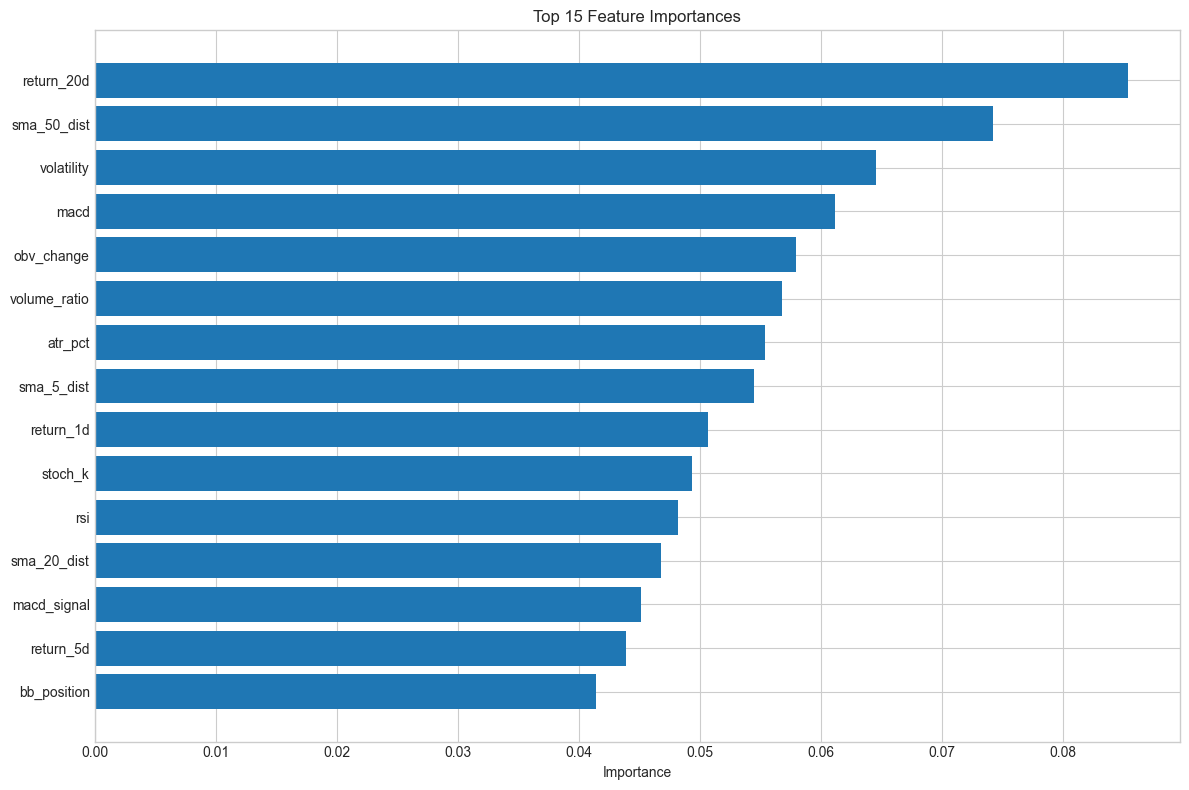


📊 Top 10 Features:
         feature  importance
2     return_20d    0.085430
6    sma_50_dist    0.074274
18    volatility    0.064569
7           macd    0.061186
17    obv_change    0.057993
16  volume_ratio    0.056787
15       atr_pct    0.055382
3     sma_5_dist    0.054528
0      return_1d    0.050695
11       stoch_k    0.049336


In [24]:
# Feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance['feature'][:15], importance['importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Features:")
print(importance.head(10))

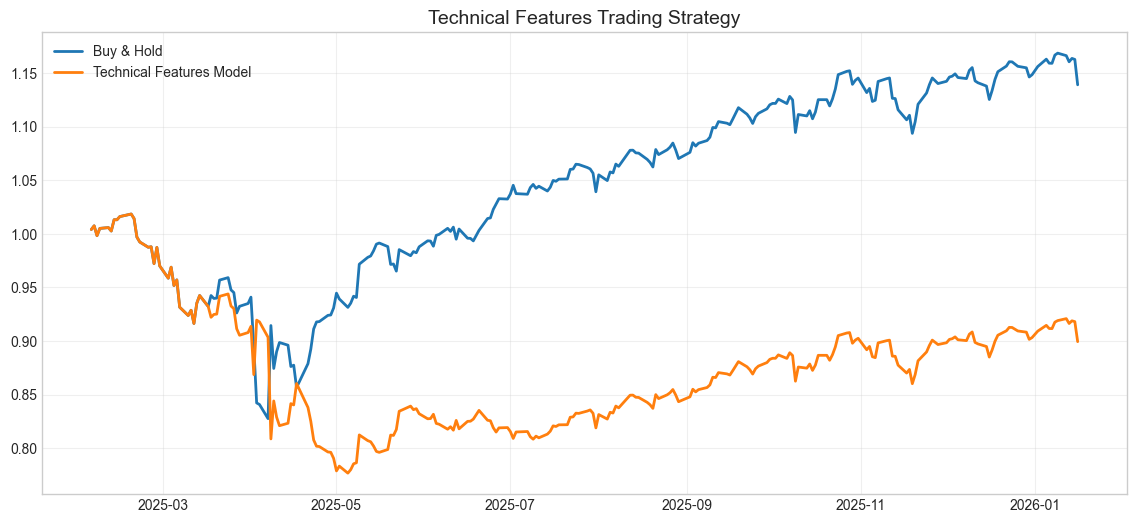

In [25]:
# Trading strategy
result = test.copy()
result['prediction'] = test_pred
result['signal'] = result['prediction'].map({1: 1, 0: -1})
result['next_return'] = result['return_1d'].shift(-1)
result['strategy_return'] = result['signal'] * result['next_return']

result = result.dropna()
result['strategy_cum'] = (1 + result['strategy_return']).cumprod()
result['buy_hold_cum'] = (1 + result['next_return']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(result.index, result['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(result.index, result['strategy_cum'], label='Technical Features Model', linewidth=2)
plt.title('Technical Features Trading Strategy', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [26]:
# Today's prediction
latest = df[feature_cols].iloc[[-1]]
latest_scaled = scaler.transform(latest)
prediction = model.predict(latest_scaled)[0]
prob = model.predict_proba(latest_scaled)[0]

print("\n" + "="*60)
print(f"📊 TODAY'S SIGNAL FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Price: ${data['Close'].iloc[-1]:.2f}")
print(f"\nKey Indicators:")
print(f"  RSI: {df['rsi'].iloc[-1]:.1f}")
print(f"  MACD: {df['macd'].iloc[-1]:.4f}")
print(f"  BB Position: {df['bb_position'].iloc[-1]:.2f}")
print(f"\n🎯 Prediction: {'📈 UP' if prediction == 1 else '📉 DOWN'}")
print(f"   Confidence: {max(prob):.1%}")


📊 TODAY'S SIGNAL FOR SPY

Date: 2026-01-20
Price: $685.40

Key Indicators:
  RSI: 38.6
  MACD: 2.3620
  BB Position: -0.07

🎯 Prediction: 📈 UP
   Confidence: 52.6%


---
## 📅 Tomorrow: Fundamental Features